In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
# !pip install -r requirements.txt

# Data: CelebA

## Dataset

In [3]:
from src.modules.classification_data_model import ClassificationDataset, Classification_Model
from src.tools.dataset_tools import get_dataset_filename_map, dataset_gdrive_download, get_labels, save_images_in_folders
import config_celeba
import os
import numpy as np

# download celeba dataset
dataset_gdrive_download(config = config_celeba)

# get labels map
# save_images_in_folders(config = config_celeba)
labels_map = get_labels(config = config_celeba, in_folders = True)

print('Number of class in label map', len(list(labels_map.keys())) )

print('\ntesting dataset')

# num_classes = 10177
num_classes=70

dataset = ClassificationDataset(labels_map, num_classes=list(range(num_classes)))
print('nb samples', len(dataset))
print('nb classes in dataloader', dataset.nb_classes())

Dataset already downloaded
Labels already downloaded
Number of class in label map 10177

testing dataset
nb samples 1573
nb classes in dataloader 70


 Train dataset ----------------------------




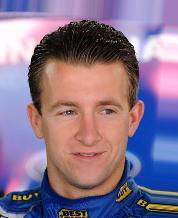

label 0
shape (178, 218)




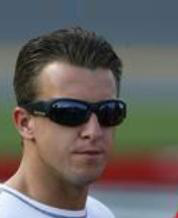

label 0
shape (178, 218)


In [4]:
#image from train dataset
print(" Train dataset ----------------------------")
for i, (image, label) in enumerate(dataset):
    print("\n")
    display(image)
    print("label",label)
    print('shape', image.size)
    if i==1:
        break


## Dataloader with custom sampler

In [5]:
import multiprocessing as mp
from src.modules.classification_data_model import DATASETS

num_classes_iter = 4
batch_size = 16
dataloader = Classification_Model(name=DATASETS.CELEBA, nb_classes=num_classes, class_split=True, batch_size = batch_size,
                               num_classes_iter=num_classes_iter, splitting_points=(0.10, 0.10),  
                               input_shape = (3, 256, 256), num_workers = mp.cpu_count(), in_folders=True)

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
if test_loader is not None:
    print("Number of test batches", len(test_loader))

train classes 0 63
test classes 63 70
split size 1242 138 193
Number of train batches 78
Number of valid batches 5
Number of test batches 7


max value 1.0
min value 0.0
shape torch.Size([16, 3, 256, 256])
[tensor(2), tensor(2), tensor(2), tensor(2)]
[tensor(10), tensor(10), tensor(10), tensor(10)]
[tensor(62), tensor(62), tensor(62), tensor(62)]
[tensor(49), tensor(49), tensor(49), tensor(49)]


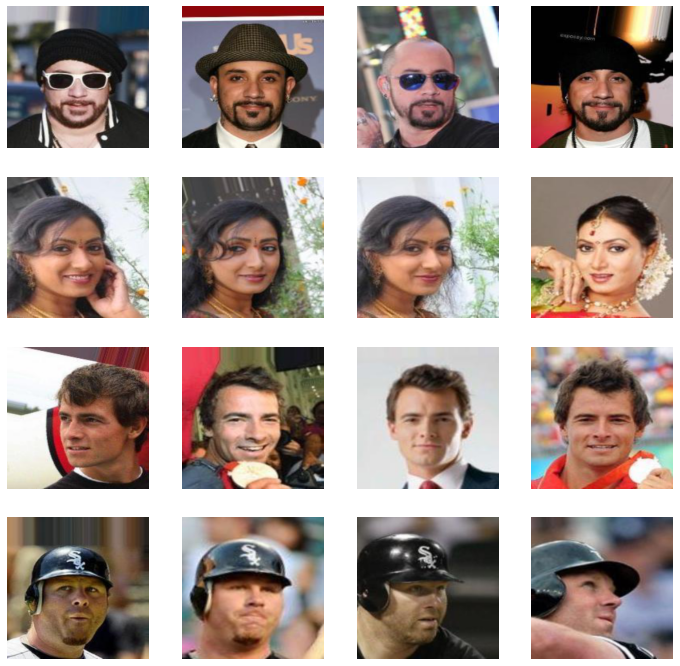

In [6]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

n_row = num_classes_iter
n_cols = int(batch_size/num_classes_iter)

for i, (im, label) in enumerate(train_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=n_row)
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(4), tensor(4), tensor(4), tensor(4)]
[tensor(16), tensor(16), tensor(16), tensor(16)]
[tensor(3), tensor(3), tensor(3), tensor(3)]
[tensor(11), tensor(11), tensor(11), tensor(11)]
[tensor(6), tensor(6), tensor(6), tensor(6)]
[tensor(33), tensor(33), tensor(33), tensor(33)]
[tensor(20), tensor(20), tensor(20), tensor(20)]
[tensor(16), tensor(16), tensor(16), tensor(16)]


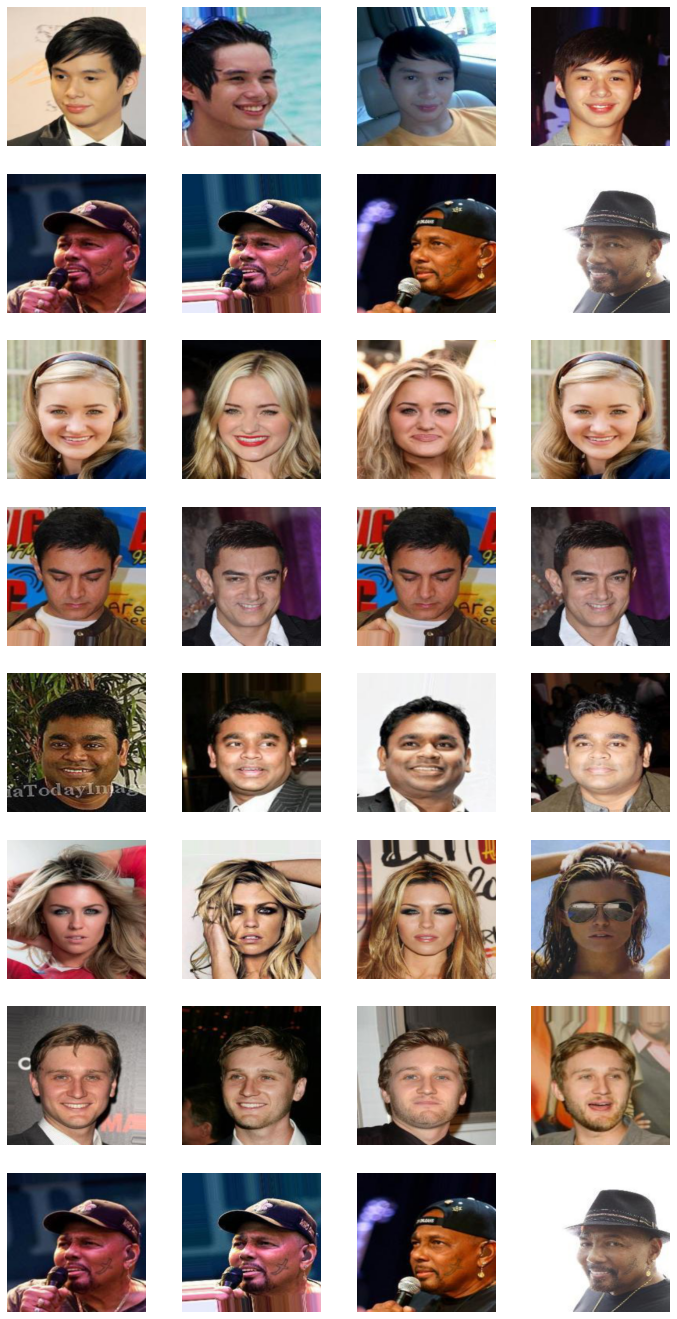

In [7]:
for i, (im, label) in enumerate(val_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(69), tensor(69), tensor(69), tensor(69)]
[tensor(69), tensor(69), tensor(69), tensor(69)]
[tensor(69), tensor(69), tensor(69), tensor(69)]
[tensor(67), tensor(67), tensor(67), tensor(67)]
[tensor(68), tensor(68), tensor(68), tensor(68)]
[tensor(69), tensor(69), tensor(69), tensor(69)]
[tensor(63), tensor(63), tensor(63), tensor(63)]
[tensor(68), tensor(68), tensor(68), tensor(68)]


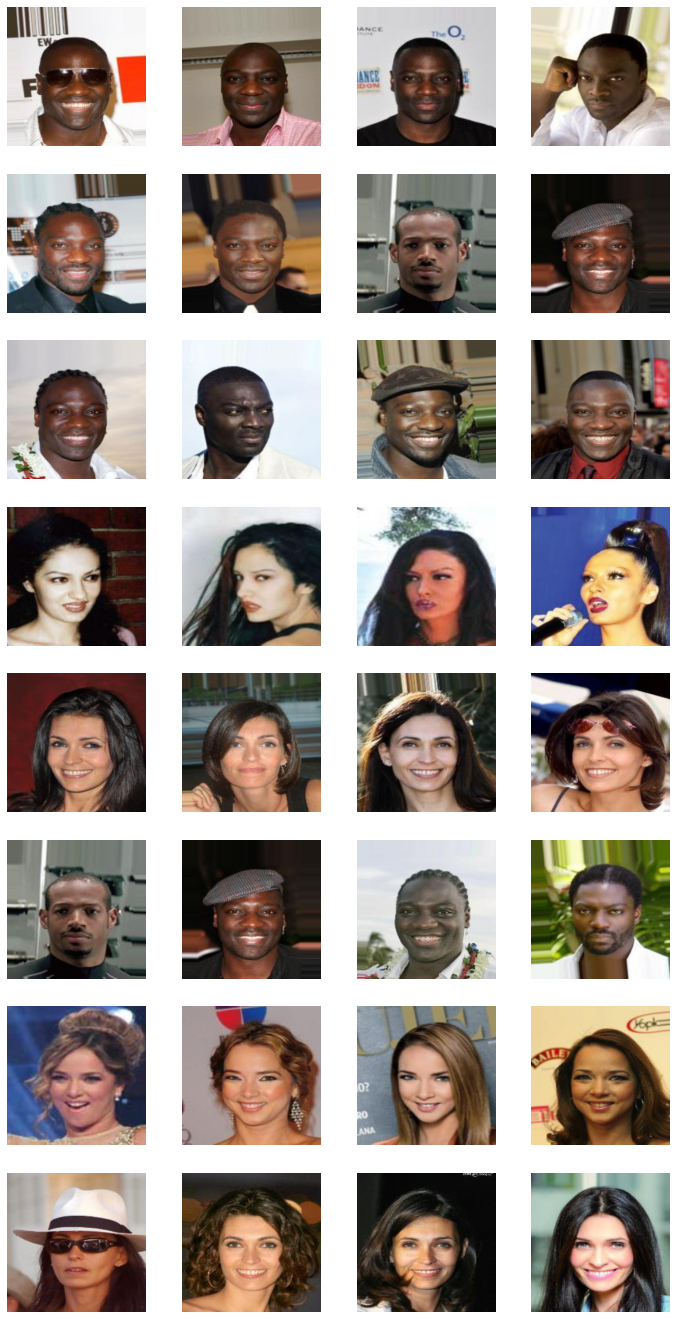

In [8]:
if test_loader is not None:
    for i, (im, label) in enumerate(test_loader):
        print('max value', torch.max(im).item())
        print('min value', torch.min(im).item())
        print('shape', im.shape)
        visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
        for j in range(0, len(label), 4):
            print(list(label[j:j+4]))

        if i == 0:
            break

# Hyperparameter Tunning

In [9]:
do_tune = False
if do_tune:
    import optuna
    from src.hyper_tune import tune

    study = optuna.create_study( direction="maximize" )
    study.optimize( tune.objective, n_trials=20 )

    print( "Number of finished trials: {}".format( len(study.trials) ) )

    print( "Best trial:" )
    trial = study.best_trial

    print( "  Value: {}".format( trial.value ) )

    print( "  Params: " )
    for key, value in trial.params.items():
      print( "    {}: {}".format( key, value ) )

# Pre-Training the model

## Choosing the model

In [10]:
finetune = False

In [11]:
from src.model.CustomModelGroupLoss import Siamese_Group, CNN_MODEL_GROUP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary
import model_configs

# cnn_model = CNN_MODEL_GROUP.MyCNN
cnn_model = CNN_MODEL_GROUP.BN_INCEPTION

num_classes = 10177
# num_classes = 50

model = Siamese_Group(hparams=model_configs.get_group_hparam(cnn_model), 
                scheduler_params = model_configs.get_group_scheduler_param(cnn_model),
                nb_classes = num_classes,
                finetune = finetune, 
                     )

if torch.cuda.is_available():
    model.to('cuda')
print(summary(model,[ (3, model.input_size, model.input_size)]))
model.cpu()
print("Model input size", model.input_size)

CNN_MODEL_GROUP.BN_INCEPTION
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,784
       BatchNorm2d-9          [-1, 192, 56, 56]             384
             ReLU-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,352
      BatchNorm2d-13           [-1, 64, 28, 28]             128
          

## Defining the Dataloader

In [12]:
if finetune:

    batch_size = 48
    dataloader = Classification_Model(name=DATASETS.CELEBA, 
                                   nb_classes=num_classes, 
                                   class_split=True, 
                                   batch_size=batch_size, 
                                   splitting_points=(0.20, 0), 
                                   input_shape = (3, model.input_size, model.input_size),
                                   num_workers = mp.cpu_count(),
                                   finetune = finetune,
                                     )

    dataloader.setup()

    train_loader = dataloader.train_dataloader()
    val_loader = dataloader.val_dataloader()
    test_loader = dataloader.test_dataloader()

    print("Number of train batches", len(train_loader))
    print("Number of valid batches", len(val_loader))
    if test_loader is not None:
        print("Number of test batches", len(test_loader))

    for i, batch in enumerate(train_loader):
        x, y = batch
        print(x.shape)
        break

In [13]:
# %tensorboard --logdir data/tb_group_logs/

## Train Classification Task

In [14]:
exp_name = 'finetune_inc'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Group-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

lr_monitor = pl.callbacks.LearningRateMonitor()

if finetune:
    callbacks = []
    if num_classes == 10177:
        callbacks = [
            early_stop_callback,
            checkpoint_callback,
            lr_monitor,
        ]
        
    trainer_params = {
        "check_val_every_n_epoch": 1, 
        "callbacks": callbacks,
        "fast_dev_run": False,
        "max_epochs": 10,
        "gpus":1 if torch.cuda.is_available() else None,

    }

    # logname = 'resnet_BCE' 
    do_train = False
    logger = None
    if do_train:
        logger = TensorBoardLogger(os.path.join('data','tb_group_logs'), name=exp_name)

    trainer = pl.Trainer(**trainer_params, logger = logger)
    if do_train:
        trainer.fit(model, dataloader)

/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/checkpoint/finetune_inc exists and is not empty. With save_top_k=3, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [15]:
from src.tools.checkpoint_tools import save_model_txt, load_model_txt

load_finetune = True
state_dict = None

checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=09-val_loss=2.29.ckpt')
if load_finetune:
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
    state_dict = model.model.state_dict()

load_ibm = False
if load_ibm:
    load_model_txt(model, checkpoint_path)
    state_dict = model.model.state_dict()
    
if state_dict is not None:
    print('loaded')
else:
    print('not loaded')

loaded


In [16]:
save_ibm = False
if save_ibm:
    ibm_dir = os.path.join(checkpoint_callback.dirpath, 'ibm')
    if not os.path.exists(ibm_dir):
        os.mkdir(ibm_dir)
        
    save_path = os.path.join(ibm_dir, 'Group-epoch=09-val_loss=2.29.txt')
    save_model_txt(model, save_path)

# Group Loss

## Model

In [17]:
from src.model.CustomModelGroupLoss import Siamese_Group, CNN_MODEL_GROUP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary
import model_configs

# cnn_model = CNN_MODEL_GROUP.MyCNN
cnn_model = CNN_MODEL_GROUP.BN_INCEPTION

num_classes = 10177
# num_classes = 50

weights_path = os.path.join('data', 'checkpoint', 'finetune_inc', 'Group-epoch=09-val_loss=2.29.ckpt')

model = Siamese_Group(hparams=model_configs.get_group_hparam(cnn_model), 
                scheduler_params = model_configs.get_group_scheduler_param(cnn_model),
                nb_classes = num_classes,
                finetune = False,
                cnn_state_dict = state_dict,
                calc_train_stats = True,
                     )

if torch.cuda.is_available():
    model.to('cuda')
print(summary(model,[ (3, model.input_size, model.input_size)]))
model.cpu()
print("Model input size", model.input_size)

CNN_MODEL_GROUP.BN_INCEPTION
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,784
       BatchNorm2d-9          [-1, 192, 56, 56]             384
             ReLU-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,352
      BatchNorm2d-13           [-1, 64, 28, 28]             128
          

## Data

In [18]:
print('len dataset', len(dataset))

load_celeb = False

if load_celeb:
    num_classes_iter = 24
    num_elem_class = 2

#     num_classes_iter = 8
#     num_elem_class = 6

    batch_size = num_classes_iter*num_elem_class

    dataloader = Classification_Model(name=DATASETS.CELEBA, 
                                   nb_classes=num_classes, 
                                   class_split=True, 
                                   batch_size=batch_size, 
                                   num_classes_iter=num_classes_iter, 
                                   splitting_points=(0.20, 0), 
                                   input_shape = (3, model.input_size, model.input_size),
                                   num_workers = mp.cpu_count(),
                                   finetune = False,
                                     )

    dataloader.setup()

    train_loader = dataloader.train_dataloader()
    val_loader = dataloader.val_dataloader()
    test_loader = dataloader.test_dataloader()

    print("Number of train batches", len(train_loader))
    print("Number of valid batches", len(val_loader))
    if test_loader is not None:
        print("Number of test batches", len(test_loader))

    for i, batch in enumerate(train_loader):
        x, y = batch
        print(x.shape)
        break

len dataset 1573


## Train

Please get the pretrained weights from https://drive.google.com/drive/folders/1tOCWXoAjKkIAvIECfQaKnZEIhl1z2ZGh?usp=sharing and place them in data/net/. for training the neural network

In [19]:
exp_name = 'group_loss_tuned_2of24_all_data_finetuned'
# exp_name = 'test'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_R%_@1',
    patience=10,
    strict=True,
    verbose=False,
    mode='max'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_R%_@1',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Group-{epoch:02d}-{val_loss:.2f}-{val_R%_@1:.2f}',
    save_top_k=10,
    mode='max',
)

lr_monitor = pl.callbacks.LearningRateMonitor()

callbacks = []
if num_classes == 10177 and load_celeb:
        callbacks = [
            early_stop_callback,
            checkpoint_callback,
            lr_monitor,
        ]
        
trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": callbacks,
    "fast_dev_run": False,
    "max_epochs": 5,
    "gpus":1 if torch.cuda.is_available() else None,
}

# logname = 'resnet_BCE'
do_train = False

logger = None
if do_train:
    logger = TensorBoardLogger(os.path.join('data','tb_group_logs'), name=exp_name)



trainer = pl.Trainer(**trainer_params, logger = logger)
if do_train:
    trainer.fit(model, dataloader)

/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/checkpoint/group_loss_tuned_2of24_all_data_finetuned exists and is not empty. With save_top_k=10, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Save/Load Checkpoint

## Manual Save

In [20]:
import os
from src.tools.checkpoint_tools import save_model_txt, load_model_txt

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'checkpoint', 'finetune_inc')  
    checkpoint_path = os.path.join(save_dir, 'Group-epoch=09-val_loss=2.29.ckpt')
    trainer.save_checkpoint(checkpoint_path)


save_ibm = False
if save_ibm:
    ibm_dir = os.path.join(checkpoint_callback.dirpath, 'ibm')
    if not os.path.exists(ibm_dir):
        os.mkdir(ibm_dir)
        
    save_path = os.path.join(ibm_dir, 'Group-epoch=24-val_loss=1.53-val_R%_@1=78.84.txt')
    save_model_txt(model, save_path)

## Load Checkpoint
Download checkpoints from https://drive.google.com/drive/folders/1puXPrBrquphElXiCDuZSIbSYdRqprxG0?usp=sharing and use the checkpoints from group loss

In [21]:
load_checkpoint = True

if load_checkpoint:
#     checkpoint_path = checkpoint_callback.best_model_path
    checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=17-val_loss=1.44-val_R%_@1=81.12.ckpt')
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
    
load_ibm = False
if load_ibm:
    load_path = os.path.join(checkpoint_callback.dirpath, 'ibm', 'Group-epoch=23-val_loss=2.96.txt')
    load_model_txt(model, load_path)

## Retrain from checkpoint

In [22]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = pl.Trainer(**trainer_params, resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [23]:
if load_celeb:
    trainer.test(model, dataloader.val_dataloader())

### Note: Computational heavy!!!!

In [24]:
calc_all_recall = False
calc_nmi = True

In [25]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model.to('cuda'), dataloader=dataloader.val_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall.detach())
    if calc_nmi:
        print('nmi', nmi)

## Run test epoch

In [26]:
if load_celeb and dataloader.test_dataloader() is not None:
    trainer.test(model, dataloader.test_dataloader())

### Note: Computational heavy!!!!

In [27]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model, dataloader=dataloader.test_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall)

    if calc_nmi:
        print('nmi', nmi)

# Test on LFW Dataset

## Create Dataloader

In [28]:
from src.tools.dataset_tools import dataset_download_targz
do_download = False
if do_download:
    dataset_download_targz()

In [29]:
# get label map
from src.tools.dataset_tools import get_dataset_filename_map, get_list_of_indices, get_transforms
import config_lfw
from src.tools.combine_sampler import CombineSampler
import torch

num_classes=1680
num_classes_iter = 8
num_elem_class = 3

# num_classes=5
# num_classes_iter = 2
# num_elem_class = 1

batch_size = num_classes_iter*num_elem_class

lfw_map = get_dataset_filename_map(config = config_lfw)
dataset = ClassificationDataset(lfw_map, 
                                num_classes=list(range(num_classes)), 
                                map_to_int=True, 
                                offset_y=0)
dataset.set_transform(get_transforms((3, model.input_size, model.input_size), mode = 'test'))

lfw_dataloader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           num_workers=mp.cpu_count(),
                                           shuffle=False,
                                           sampler=CombineSampler(
                                                get_list_of_indices(dataset),
                                                num_classes_iter,
                                                num_elem_class),
                                           collate_fn=None,
                                           )
print(len(lfw_dataloader))

382


## Test

In [30]:
trainer.test(model, lfw_dataloader)

running test
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_ce_loss': tensor(12.1332),
 'avg_loss': tensor(12.7684),
 'avg_nll_loss': tensor(0.6352),
 'avg_recall@1': tensor(0.9461)}
--------------------------------------------------------------------------------



/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'avg_loss': 12.76841926574707,
  'avg_recall@1': 0.9461169838905334,
  'avg_nll_loss': 0.6351988911628723,
  'avg_ce_loss': 12.133220672607422}]

In [31]:
calc_all_recall = False
calc_nmi = False

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model, dataloader=lfw_dataloader,
                                           calc_nmi=calc_nmi, nb_batches=500)
    print('recall', recall)

    if calc_nmi:
        print('nmi', nmi)

# Inference and Visualization

In [32]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn

def visualize_dataset(dataloader):
    for x, y, indices, distances in get_k_similar_group(model, loader=dataloader):
        print(x.shape)
        print(indices.shape)
        for img_idx, closest_idx in enumerate(indices[:, 0]):
            if img_idx % 3 == 0:
                img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
                caption = f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx])
                visualize_torch(img_matches, n_cols=2, n_rows=1, caption=caption)
                if int(img_idx) == 15:
                    break
        break

In [33]:
if load_celeb:
    visualize_dataset(dataloader.val_dataloader())

In [34]:
if load_celeb and dataloader.test_dataloader() is not None:
    visualize_dataset(dataloader.test_dataloader())

In [35]:
### Test
from src.tools.model_tools import get_similar_ind
def test_emb(dataloader):
    for batch in lfw_dataloader:
        x, y = batch
        print(x.size())
        
        x_1 = x[0].unsqueeze(0)
        x_2 = x[1].unsqueeze(0)
        
        print(x_1.size())
        
        fc_1, _ = evaluation_tool.inference_group(model, None, X=x_1)
        fc_2, _ = evaluation_tool.inference_group(model, None, X=x_2)
        emb = torch.cat([fc_1, fc_2]).squeeze()
        print('emb', emb.shape)
        
        indices, distances = get_similar_ind(k=1, model=model, emb=emb, batch=None, images=None)
        print(distances[0][1])
        indices, distances_2 = get_similar_ind(k=1, model=model, emb=None, batch=None, images=x)
        print(distances_2[0][1])
        break

In [36]:
### test
test_emb(lfw_dataloader)

torch.Size([24, 3, 224, 224])
torch.Size([1, 3, 224, 224])
emb torch.Size([2, 1024])
0.624139
0.624139


## Visualize LFW

torch.Size([24, 3, 224, 224])
(24, 1)


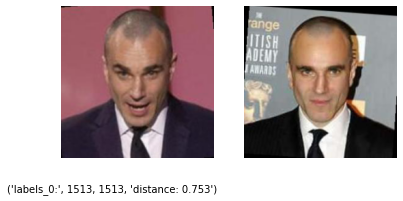

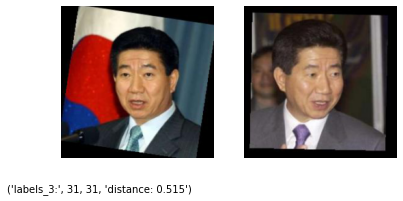

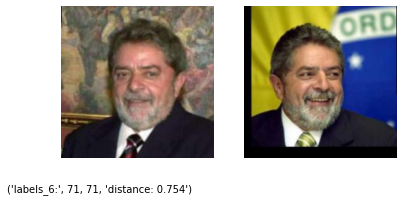

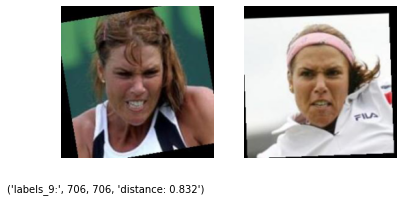

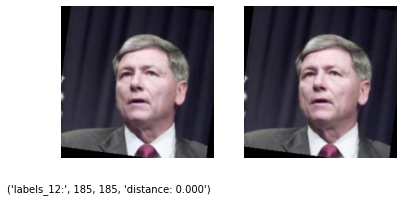

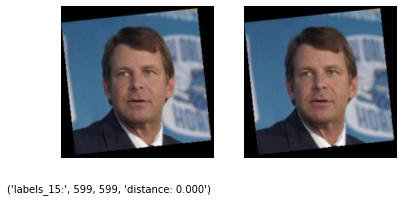

In [37]:
visualize_dataset(lfw_dataloader)